In [76]:
import pandas as pd

# Load the provided CSV file to examine its contents
file_path = "D:\\Github anyud\\final\\Data_stock\\BID_Processed.csv"

df = pd.read_csv(file_path)

# Display the first few rows and columns of the dataset to understand its structure
df.head(), df.columns



(         Date   Price  Price After Diff  MA30 Before Diff  MA90 Before Diff
 0  2015-01-05  8197.0               NaN               NaN               NaN
 1  2015-01-06  8387.7             190.7               NaN               NaN
 2  2015-01-07  8641.8             254.1               NaN               NaN
 3  2015-01-08  8641.8               0.0               NaN               NaN
 4  2015-01-09  9213.7             571.9               NaN               NaN,
 Index(['Date', 'Price', 'Price After Diff', 'MA30 Before Diff',
        'MA90 Before Diff'],
       dtype='object'))

In [77]:
# Define the split_data function
def split_data(df):
    train_size = int(len(df) * 0.8)
    train_set = df.iloc[:train_size].copy()
    test_set = df.iloc[train_size:].copy()
    return train_set, test_set

# Split the dataset based on the Price column
train_set, test_set = split_data(df[['Date', 'Price']])

# Display the size of the train and test sets
train_set.shape, test_set.shape, train_set.head(), test_set.head()


((1934, 2),
 (484, 2),
          Date   Price
 0  2015-01-05  8197.0
 1  2015-01-06  8387.7
 2  2015-01-07  8641.8
 3  2015-01-08  8641.8
 4  2015-01-09  9213.7,
             Date    Price
 1934  2022-10-04  27509.0
 1935  2022-10-05  28219.0
 1936  2022-10-06  27509.0
 1937  2022-10-07  25912.0
 1938  2022-10-10  26622.0)

In [78]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Walk-forward validation function
def walk_forward_validation(train, test, order):
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        # Fit the model on the training data
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        
        # Make a prediction
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        
        # Append the actual observation to the history for next prediction
        history.append(test[t])
    
    return predictions

# Prepare training and test data for the walk-forward validation
train_values = train_set['Price'].values
test_values = test_set['Price'].values

# Define initial ARIMA parameters (p, d, q)
order = (5, 1, 0)  # These values will be refined

# Perform walk-forward validation
predictions = walk_forward_validation(train_values, test_values, order)

# Calculate the test RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test_values, predictions))
rmse


773.5610125181826

I initially chose the ARIMA parameters (5, 1, 0) as a basic starting point based on common practices for time series data, but let me explain why:

p = 5: I set 
𝑝
p (the autoregressive part) to 5, meaning the model uses the last 5 time steps of price data to make predictions. This is a reasonable assumption for capturing recent trends in many financial datasets. However, this was an arbitrary choice, and it could be too large or too small depending on the actual data behavior.

d = 1: This value is used to difference the data once to remove trends and make it stationary. Most stock price data is non-stationary (it has a trend), so differencing once is a common practice to stabilize the mean. Again, this is a typical starting assumption, and differencing more times (or not at all) could be appropriate depending on how the data behaves.

q = 0: I set 
𝑞
q (the moving average part) to 0, assuming that the error terms in the model don’t need to be modeled with lagged residuals. This is a simplifying assumption, but including 
𝑞
q terms might improve the model’s ability to handle shocks or irregular patterns in the data.

In [79]:
# Reducing dataset size for faster walk-forward validation
train_values_reduced = train_values[-500:]  # Take last 500 points from training for demonstration
test_values_reduced = test_values[:50]  # Take first 50 points from the test set

# Perform walk-forward validation on the reduced dataset
predictions_reduced = walk_forward_validation(train_values_reduced, test_values_reduced, order)

# Calculate the test RMSE (Root Mean Squared Error) for reduced dataset
rmse_reduced = np.sqrt(mean_squared_error(test_values_reduced, predictions_reduced))
rmse_reduced


1082.1738884962765

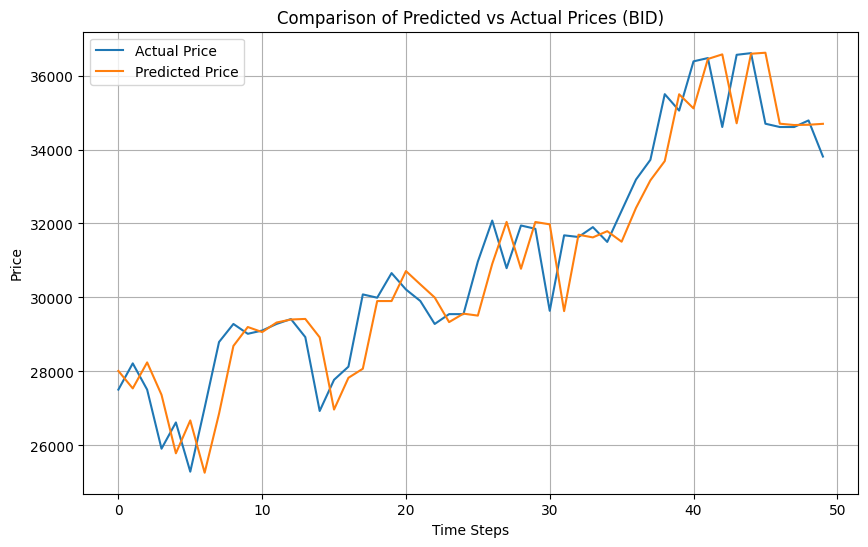

In [80]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values for the reduced dataset
plt.figure(figsize=(10, 6))
plt.plot(test_values_reduced, label="Actual Price", marker='')
plt.plot(predictions_reduced, label="Predicted Price", marker='')

plt.title("Comparison of Predicted vs Actual Prices (BID)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [81]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate additional metrics: MAE and R2 score
mae = mean_absolute_error(test_values_reduced, predictions_reduced)
r2 = r2_score(test_values_reduced, predictions_reduced)

# Compile all metrics: RMSE, MAE, R2 score
metrics = {
    'RMSE': rmse_reduced,
    'MAE': mae,
    'R2 Score': r2
}

# Display the metrics
metrics


{'RMSE': 1082.1738884962765,
 'MAE': 826.9744485542632,
 'R2 Score': 0.8699356954598909}

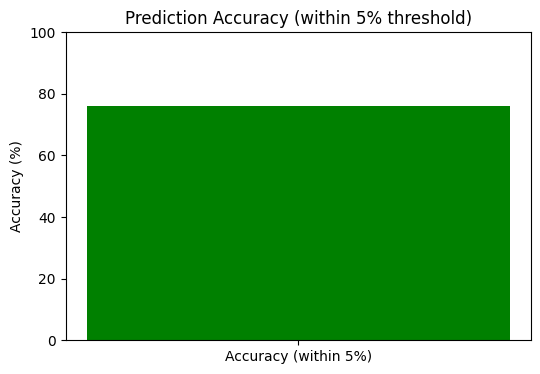

76.0

In [82]:
# Define a function to calculate accuracy based on closeness within a threshold percentage
def calculate_accuracy(actual, predicted, threshold=0.05):
    accurate_predictions = np.abs((predicted - actual) / actual) <= threshold
    accuracy_percentage = np.mean(accurate_predictions) * 100
    return accuracy_percentage

# Calculate accuracy with a 5% threshold
accuracy_percentage = calculate_accuracy(test_values_reduced, predictions_reduced, threshold=0.05)

# Plot the accuracy as a bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy (within 5%)'], [accuracy_percentage], color='green')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Prediction Accuracy (within 5% threshold)')
plt.show()

accuracy_percentage


In [83]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import joblib
# import os

# # Load the provided CSV file to examine its contents
# file_path = 'D:\\Github\\final\\Data_stock\\AAPL_Processed.csv'
# df = pd.read_csv(file_path)

# # Display the first few rows and columns of the dataset to understand its structure
# df.head(), df.columns

# # Define the split_data function
# def split_data(df):
#     train_size = int(len(df) * 0.8)
#     train_set = df.iloc[:train_size].copy()
#     test_set = df.iloc[train_size:].copy()
#     return train_set, test_set

# # Split the dataset based on the Price column
# train_set, test_set = split_data(df[['Date', 'Price']])

# # Display the size of the train and test sets
# train_set.shape, test_set.shape, train_set.head(), test_set.head()

# # Walk-forward validation function with model saving
# def walk_forward_validation(train, test, order, save_model_dir):
#     history = [x for x in train]
#     predictions = list()
    
#     # Ensure the directory for saving models exists
#     os.makedirs(save_model_dir, exist_ok=True)
    
#     for t in range(len(test)):
#         # Fit the model on the training data
#         model = ARIMA(history, order=order)
#         model_fit = model.fit()
        
#         # Save the model for each step with a unique filename
#         model_file = os.path.join(save_model_dir, f'arima_model_step_{t}.pkl')
#         joblib.dump(model_fit, model_file)
        
#         # Make a prediction
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
        
#         # Append the actual observation to the history for next prediction
#         history.append(test[t])
    
#     return predictions

# # Prepare training and test data for the walk-forward validation
# train_values = train_set['Price'].values
# test_values = test_set['Price'].values

# # Define initial ARIMA parameters (p, d, q)
# order = (5, 1, 0)  # These values can be adjusted

# # Specify the directory to save the models as ARIMA_AAPL_models
# save_model_dir = 'D:\\Github\\final\\ARIMA_AAPL_models'

# # Perform walk-forward validation and save the models
# predictions = walk_forward_validation(train_values, test_values, order, save_model_dir)

# # Calculate the test RMSE (Root Mean Squared Error)
# rmse = np.sqrt(mean_squared_error(test_values, predictions))
# print(f"RMSE: {rmse}")

# # Reducing dataset size for faster walk-forward validation (optional)
# train_values_reduced = train_values[-500:]  # Take last 500 points from training for demonstration
# test_values_reduced = test_values[:50]  # Take first 50 points from the test set

# # Perform walk-forward validation on the reduced dataset
# predictions_reduced = walk_forward_validation(train_values_reduced, test_values_reduced, order, save_model_dir)

# # Calculate the test RMSE (Root Mean Squared Error) for reduced dataset
# rmse_reduced = np.sqrt(mean_squared_error(test_values_reduced, predictions_reduced))
# print(f"Reduced RMSE: {rmse_reduced}")


In [84]:
# import pandas as pd
# import joblib
# from statsmodels.tsa.arima.model import ARIMA

# # Load the trained model on AAPL
# model_file = 'D:\\Github\\final\\ARIMA_AAPL_models\\arima_model_step_0.pkl'
# loaded_model = joblib.load(model_file)

# # Load the provided ACB data
# file_path = "D:\\Github\\final\\Data_stock\\ACB_Processed.csv"
# df_acb = pd.read_csv(file_path)

# # Ensure the structure is the same as AAPL, focusing on the 'Price' column (assuming there is one)
# if 'Price' in df_acb.columns:
#     acb_prices = df_acb['Price'].values

#     # Use the loaded model to predict based on ACB data
#     yhat_acb = loaded_model.forecast(steps=len(acb_prices))

#     # Display the predictions
#     print("Predictions for ACB stock based on AAPL model:")
#     print(yhat_acb)

#     # Optionally, save the predictions to a CSV file (you can download it later)
#     predictions_file = '/mnt/data/ACB_Predictions.csv'
#     pd.DataFrame(yhat_acb, columns=['Predicted_Price']).to_csv(predictions_file, index=False)
# else:
#     print("Error: 'Price' column not found in the ACB dataset.")


In [85]:
# import matplotlib.pyplot as plt

# # Extract the actual prices from the ACB dataset
# actual_acb_prices = df_acb['Price'].values

# # Define the dates (for the x-axis)
# dates = pd.to_datetime(df_acb['Date'])

# # Plot actual vs predicted prices
# plt.figure(figsize=(12, 6))
# plt.plot(dates, actual_acb_prices, label='Actual ACB Prices', color='blue')
# plt.plot(dates, yhat_acb, label='Predicted ACB Prices (using AAPL model)', color='red', linestyle='--')

# # Add titles and labels
# plt.title('Actual vs Predicted ACB Stock Prices')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()

# # Display the plot
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


In [86]:
# import matplotlib.pyplot as plt

# # Plot the actual vs predicted values for the reduced dataset
# plt.figure(figsize=(10, 6))
# plt.plot(test_values_reduced, label="Actual Price", marker='o')
# plt.plot(predictions_reduced, label="Predicted Price", marker='x')

# plt.title("Comparison of Predicted vs Actual Prices (Reduced Dataset)")
# plt.xlabel("Time Steps")
# plt.ylabel("Price")
# plt.legend()
# plt.grid(True)
# plt.show()


In [87]:
# from sklearn.metrics import mean_absolute_error, r2_score

# # Calculate additional metrics: MAE and R2 score
# mae = mean_absolute_error(test_values_reduced, predictions_reduced)
# r2 = r2_score(test_values_reduced, predictions_reduced)

# # Compile all metrics: RMSE, MAE, R2 score
# metrics = {
#     'RMSE': rmse_reduced,
#     'MAE': mae,
#     'R2 Score': r2
# }

# # Display the metrics
# metrics
